# Facemask detection


1. Download face mask lite dataset from kaggle
2. Unzip into folder named "data"

In [38]:
# module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms, utils
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix

## A - Dataset preparation and data loading
First, we define data directories for training, validation, and testing datasets. <br>
Training data contains 7000 images of faces with masks and 7000 matching images of faces without masks. <br>
The validation dataset contains 2000 images of faces with masks and 2000 matching images of faces without masks. <br>
The testing dataset contains 1000 images of faces with masks and 1000 matching images of faces without masks. <br>
Then, we apply a transformation to the data to improve training. These transformations include rotation, translation, flip, and conversion of all images to `PyTorch tensors`. <br>
Finally, we use ImageFolder and provide it the appropriate DataLoader. `ImageFolder` takes a dataset and returns batches of images and corresponding labels.

### References
1. `Loading images using PyTorch`, Archit, Jul 12, 2019. <br>
https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2

2. `[PyTorch] 1. Transform, ImageFolder, DataLoader`, Jun, Apr 1, 2020. <br>
https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0

3. `A Comprehensive Guide to the DataLoader Class and Abstractions in PyTorch`, Vihar Kurama, Dec, 2020. <br>
https://blog.paperspace.com/dataloaders-abstractions-pytorch/

4. `PyTorch` documentation.<br>
https://pytorch.org/docs/0.3.0/index.html




In [20]:
# Loading data preps
train_data_dir = "data/train_dataset"
val_data_dir = "data/validation_dataset"
test_data_dir = "data/test_dataset"

batch_size_train = 64
batch_size = 1
image_size = 1024
epochs = 35


In [21]:
# Using GPU for faster training
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

In [35]:
# Data transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    ])


In [23]:
# Applying transforms
train_data = datasets.ImageFolder(train_data_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_data_dir, transform=val_transform)


In [24]:
# Data Loading

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, **kwargs)



In [25]:
# Function to show images
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()


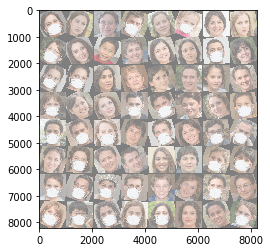

In [26]:
images, labels = next(iter(train_loader))
# The labels are 0 for mask and 1 for no mask

imshow(torchvision.utils.make_grid(images))


In [32]:
# Exploring and image
print(images[0].shape)
print(labels[0]) # 

torch.Size([3, 1024, 1024])
tensor(1)


## Building the CNN with the `sequential` module

In [41]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        # Variables
        k_size = 3
        stride = 1
        padding = 1
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            # First convolutional layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 1024),
            # Second convolutional layers
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 1024),
            # Third convolutional layers
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=k_size, stride=stride, padding=padding),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 28),
            # Fourth convolutional layers
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 1024),
            # Fith convolutional layers
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=k_size, stride=stride, padding=padding),
            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ReLU nonlinearity
            nn.ReLU(inplace=True),
            # Batch Normalization
            nn.BatchNorm2d(num_features = 1024)
        )
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(128 * 128 * 512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024), 
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    # Forward method
    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 128 * 128 * 512)
        # Classify the images
        x = self.classifier(x)
        return x




## Training the model

### Optimizer with L2-regularization and Loss Function

In [42]:
# Instantiate the network
model = Net()

# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)

In [ ]:
# keeping track of losses 
train_losses = []
valid_losses = []

print("starting training.")

for epoch in range(100):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0

    # Training the model
    model.train()
    for i, data in enumerate(train_loader, 0):
    # Get the inputs and move tensor to GPU
    inputs, labels = train_data.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Compute the forward pass
    outputs = net(inputs)
        
    # Compute the loss function
    loss = criterion(outputs, labels)
        
    # Compute the gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()

    # update training loss
    train_loss += loss.item() * inputs.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    # print training statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

print("Training completed")

## Evaluating the model


In [ ]:
correct, total = 0, 0
predictions = []

model.eval()

# Iterate over the data in the test_loader
for i, data in enumerate(val_loader, 0):
  
    # Get the image and label from data
    images, labels = val_data.to(device)
    
    # Make a forward pass in the net with your image
    outputs = net(images)
    
    # Argmax the results of the net
    _, predicted = torch.max(output.data, 1)
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # update average validation loss 
    valid_loss += loss.item() * images.size(0)

    # calculate average losses
    valid_loss = valid_loss/len(val_loader.sampler)
    valid_losses.append(valid_loss)

    # print validation statistics 
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, valid_loss))

    # Print predictions
    if predicted == labels:
        print("Yipes, the net made the right prediction " + str(predicted))
    else:
        print("The net prediction was " + str(predicted) + ", but the correct label is: " + str(labels))

print("The testing set accuracy of the network is: %d %%" % (100 * correct / total))